# Causal Success Analysis: API Demonstration

**Purpose:** Introduce and explore each core function in isolation before moving on to the full analysis.

This notebook is meant to be a hands-on walkthrough of the building blocks behind the project. We import the simulation code and experiment with each component one at a time to understand what it does and why it matters.

If you’re interested in seeing how all of these pieces come together in a complete analysis—simulation, causal inference, and policy comparison—take a look at `causal_success_example.ipynb`.

You can think of this notebook as getting familiar with the individual tools before using them together in a full wrkflow.


## Setup: Import Everything

First we need to bring in the functions we're going to demonstrate.

In [12]:
import sys
from pathlib import Path

# -------------------------------------------------------------------
# Ensure the project module is importable (works locally and in Docker)
# -------------------------------------------------------------------
project_root = Path.cwd()

if (project_root / "causal_success_utils.py").exists():
    sys.path.insert(0, str(project_root))
elif Path("/app/causal_success_utils.py").exists():
    sys.path.insert(0, "/app")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import simulation components
from causal_success_utils import (
    Agent,
    create_population,
    run_simulation,
    run_policy_simulation,
    calculate_gini,
    get_results_dataframe,
    generate_summary_statistics,
    validate_simulation_results,
)

# Plotting configuration
%matplotlib inline
plt.style.use("seaborn-v0_8-darkgrid")

print("Environment configured successfully")
print(f"NumPy version:  {np.__version__}")
print(f"Pandas version: {pd.__version__}")

Environment configured successfully
NumPy version:  1.24.3
Pandas version: 2.0.3


## Demo 1: Creating a Single Agent

Let’s create one simulated person and take a quick look at their starting traits and stat.


In [13]:
# Create a single agent with chosen talent levels
person = Agent(
    agent_id=0,
    intensity=0.7,  # High activity / exposure
    iq=0.6,  # Moderately good at exploiting opportunities
    networking=0.4,  # Below-average social reach
    initial_capital=1.0,
)

print("Agent created successfully")

print(f"\nAgent ID: {person.id}")

print("\nTalent profile:")
for name, value in person.talent.items():
    print(f"  {name:18s}: {value:.3f}")

print(f"\nStarting capital: ${person.capital:.2f}")
print(f"Talent norm (combined ability): {person.talent_norm:.3f}")
print(f"Event exposure probability: {person.get_event_probability():.3f}")

Agent created successfully

Agent ID: 0

Talent profile:
  intensity         : 0.700
  iq                : 0.600
  networking        : 0.400
  initial_capital   : 1.000

Starting capital: $1.00
Talent norm (combined ability): 1.418
Event exposure probability: 0.599


**What to notice:**

The event exposure probability is computed using a sigmoid function of the agent’s intensity. With an intensity of 0.7, this agent has **above-average exposure** to events, resulting in an exposure probability of about **0.60**. An agent with lower intensity (for example, 0.3) would have noticeably less exposure, while higher intensity values push the probability closer to 1.

The talent norm is simply the Euclidean norm of the talent vector (intensity, IQ, networking, and initial capital). It provides a single summary measure of overall capability. This value is useful for analysis and comparison, but it does not directly determine success on its own—outcomes still depend heavily on the sequence of events the agent experienes.


## Demo 2: Applying Events to an Agent

Next, we’ll apply a few lucky and unlucky events to the same agent and watch how their capital change.


In [14]:
print(f"Starting capital: ${person.capital:.2f}")

print("\nApplying a lucky event (30% gain)...")
person.apply_event("lucky", 0.30)
print(f"Capital after lucky event: ${person.capital:.2f}")

print("\nApplying an unlucky event (20% loss)...")
person.apply_event("unlucky", 0.20)
print(f"Capital after unlucky event: ${person.capital:.2f}")

print("\nApplying another lucky event (25% gain)...")
person.apply_event("lucky", 0.25)
print(f"Final capital: ${person.capital:.2f}")

print("\nEvent summary:")
print(f"  Lucky events:   {person.lucky_events}")
print(f"  Unlucky events:{person.unlucky_events:>3}")
print(f"  Net events:    {person.lucky_events - person.unlucky_events:>3}")

print("\nCapital history:")
for t, value in enumerate(person.capital_history):
    print(f"  Step {t:2d}: ${value:.2f}")

Starting capital: $1.00

Applying a lucky event (30% gain)...
Capital after lucky event: $1.30

Applying an unlucky event (20% loss)...
Capital after unlucky event: $1.04

Applying another lucky event (25% gain)...
Final capital: $1.30

Event summary:
  Lucky events:   2
  Unlucky events:  1
  Net events:      1

Capital history:
  Step  0: $1.00
  Step  1: $1.30
  Step  2: $1.04
  Step  3: $1.30


**Key insight:**

Events affect capital multiplicatively rather than additively. A 30% gain on \$1.00 increases capital to \$1.30. A subsequent 20% loss then removes 20% of \$1.30 (not of the original \$1.00), leaving \$1.04. When another lucky event occurs, its impact is applied to this new level.

Because each change is a percentage of the current capital, the **order and timing of events matter**. Early gains raise the base on which future gains and losses are calculated, while early setbacks shrink it.

Over many periods, this compounding effect can produce large differences in outcomes, even when agents start with identical resources and similar abilties.


## Demo 3: Creating a Population

So far we’ve looked at a single individual. Now we’ll scale things up and create a small population of agents, each with randomly assigned talents drawn from the same underlying distribution.


In [15]:
# Create a small population
agents = create_population(n_agents=20, seed=42)

print(f"Created {len(agents)} agents\n")

# Look at the first 5
print("First 5 agents:")
print(
    f"{'ID':>3} {'Intensity':>10} {'IQ':>10} {'Networking':>10} {'Capital':>10}"
)
print("+" * 50)
for i in range(5):
    a = agents[i]
    print(
        f"{a.id:3d} {a.talent['intensity']:10.3f} {a.talent['iq']:10.3f} {a.talent['networking']:10.3f} ${a.capital:9.2f}"
    )

# Check distribution of one talent
intensities = [a.talent["intensity"] for a in agents]
print("\nIntensity statistics:")
print(f"  Mean: {np.mean(intensities):.3f}")
print(f"  Std: {np.std(intensities):.3f}")
print(f"  Min: {np.min(intensities):.3f}")
print(f"  Max: {np.max(intensities):.3f}")

Created 20 agents

First 5 agents:
 ID  Intensity         IQ Networking    Capital
++++++++++++++++++++++++++++++++++++++++++++++++++
  0      0.546      0.344      0.613 $     1.00
  1      0.641      0.207      0.305 $     1.00
  2      0.519      0.453      0.497 $     1.00
  3      0.372      0.632      0.617 $     1.00
  4      0.510      0.669      0.570 $     1.00

Intensity statistics:
  Mean: 0.527
  Std: 0.120
  Min: 0.371
  Max: 0.821


**What’s happening:**

Each talent dimension is drawn independently from a normal distribution with mean 0.5 and standard deviation 0.15, then clipped to stay within the \([0, 1]\) range. As expected, most values cluster near 0.5 with moderate spread, which is reflected in the summary statistics above.

At this point, all agents still have exactly \$1.00 in capital. There is variation in *potential* (talents), but no variation in *outcomes* yet. Any inequality that appears later will be the result of how random events interact with these talents over time, not differences in starting weath.


## Demo 4: Running a Short Simulation

Now we’ll let the population evolve over time. We’ll run a short simulation with 20 agents over 10 periods to see how differences in outcomes begin to emerge.


In [16]:
# Run a short simulation
print("Running simulation: 20 agents, 10 periods...\n")

agents = run_simulation(
    agents=agents,
    n_periods=10,
    n_lucky_events_per_period=3,
    n_unlucky_events_per_period=3,
    seed=42,
    verbose=False,
)

print("Simulation complete!\n")

# Show what changed
print("After 10 periods:")
print(f"{'ID':>3} {'Capital':>10} {'Lucky':>6} {'Unlucky':>8} {'Net':>5}")
print("+" * 40)
for a in agents[:5]:
    print(
        f"{a.id:3d} ${a.capital:9.2f} {a.lucky_events:6d} {a.unlucky_events:8d} {a.lucky_events - a.unlucky_events:5d}"
    )

# Simple statistics
capitals = [a.capital for a in agents]
print(f"\nCapital range: ${min(capitals):.2f} to ${max(capitals):.2f}")
print(f"Mean capital: ${np.mean(capitals):.2f}")
print(f"Spread: {max(capitals) / min(capitals):.1f}x")

Running simulation: 20 agents, 10 periods...

Simulation complete!

After 10 periods:
 ID    Capital  Lucky  Unlucky   Net
++++++++++++++++++++++++++++++++++++++++
  0 $     0.87      0        1    -1
  1 $     1.00      1        2    -1
  2 $     1.63      4        1     3
  3 $     0.76      0        2    -2
  4 $     0.73      0        2    -2

Capital range: $0.46 to $1.63
Mean capital: $0.97
Spread: 3.5x


**What to notice:**

Even over just 10 periods, noticeable differences in outcomes have already emerged. Capital now ranges from about \$0.46 to \$1.63, a spread of roughly **3.5×**, despite all agents starting with exactly \$1.00.

These differences are driven primarily by **event histories**. For example, Agent 2 experienced several more lucky than unlucky events and ended up well ahead of the population mean, while Agents 3 and 4 encountered multiple unlucky events and fell behind. The mean capital remains close to \$1.00, indicating that gains by some agents are largely offset by losses elsewhere.

This short run illustrates the core mechanism of the model: random events, combined with multiplicative updates, quickly generate dispersion in outcomes. While inequality is still limited at this horizon, extending the simulation in time or increasing event frequency amplifies these differences substantially, which motivates the longer simulations examined later in the anaysis.


## Demo 5: Calculating the Gini Coefficient

To quantify how unequal the outcomes have become, we use the **Gini coefficient**, a standard measure of inequality widely used in economics and social scienc.


In [6]:
# Get capital values
capital_values = np.array([a.capital for a in agents])

# Calculate Gini
gini = calculate_gini(capital_values)

print(f"Gini coefficient: {gini:.3f}")
print("\nInterpretation:")
if gini < 0.30:
    print("  → Relatively equal distribution")
elif gini < 0.50:
    print("  → Moderate inequality")
else:
    print("  → High inequality")

# Compare to perfect equality
equal_values = np.ones(20)
gini_equal = calculate_gini(equal_values)
print(f"\nGini if everyone had equal capital: {gini_equal:.3f}")

# Compare to extreme inequality
extreme_values = np.zeros(20)
extreme_values[0] = 20.0
gini_extreme = calculate_gini(extreme_values)
print(f"Gini if one person had everything: {gini_extreme:.3f}")

Gini coefficient: 0.117

Interpretation:
  → Relatively equal distribution

Gini if everyone had equal capital: 0.000
Gini if one person had everything: 0.950


**Understanding the Gini coefficient:**

A Gini value of 0 represents perfect equality, where everyone has exactly the same amount. A value close to 1 represents extreme inequality, where nearly all resources are concentrated in the hands of a single individual.

In this short simulation, the Gini coefficient is **0.117**, indicating that outcomes are still relatively equal. This is expected given the small number of periods and events. Inequality has begun to emerge, but it remains modest at this stage.

As the simulation runs for more periods, the Gini coefficient typically increases. In longer runs (for example, 80 periods), values often rise into the **0.35–0.45** range, reflecting how multiplicative gains and losses compound over time to produce much stronger inequality.


## Demo 6: Converting to DataFrame

DataFrames make analysis much easier than working with lists of objects.

In [7]:
# Convert to DataFrame
df = get_results_dataframe(agents)

print("First few rows:\n")
print(df.head())

print(f"\nDataFrame shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# Now we can do easy pandas operations
print("\nBasic statistics:")
print(
    df[["capital", "talent_norm", "lucky_events", "unlucky_events"]].describe()
)

First few rows:

   id  talent_intensity  talent_iq  talent_networking  initial_capital  \
0   0          0.545708   0.344002           0.612568              1.0   
1   1          0.641085   0.207345           0.304673              1.0   
2   2          0.519176   0.452564           0.497480              1.0   
3   3          0.372043   0.631910           0.616669              1.0   
4   4          0.509905   0.669086           0.570126              1.0   

   talent_norm   capital  lucky_events  unlucky_events  net_events  
0     1.338422  0.873118             0               1          -1  
1     1.243707  0.996856             1               2          -1  
2     1.312190  1.633899             4               1           3  
3     1.384921  0.761320             0               2          -2  
4     1.425736  0.727726             0               2          -2  

DataFrame shape: (20, 10)
Columns: ['id', 'talent_intensity', 'talent_iq', 'talent_networking', 'initial_capital', 'talent_

**Why DataFrames matter:**

Representing the simulation results as a DataFrame makes patterns much easier to see and analyze. Each row corresponds to a single agent, and each column captures either a talent attribute, an event count, or a final outcome.

From the summary statistics, we can already observe several important facts. Average capital remains close to \$1 00, which is consistent with gains and losses roughly balancing out over this short run. At the same time, there is meaningful dispersion: some agents accumulated over \$1.60 after experiencing multiple lucky events, while others suffered repeated unlucky events and fell below \$0.50.

Using a DataFrame allows us to compute correlations, rank agents by outcomes, and prepare the data for causal analysis methods in later sections. These operations would be cumbersome and error-prone if we worked directly with lists of agent obcts.
jects.
ects.
ects.


## Demo 7: Summary Statistics Function

Rather than calculating each metric by hand, we can use a helper function that summarizes the entire simulation in one step.

This function returns all the key quantities you would typically report: inequality measures, distributional statistics, and average event counts. It provides a quick snapshot of how the system evolved and is especially useful when comparing multiple simulation runs or policy scenaros.


In [17]:
# Generate comprehensive statistics
stats = generate_summary_statistics(agents)

print("Complete Summary Statistics:\n")
print("=" * 50)
for key, value in stats.items():
    if "share" in key or "coefficient" in key:
        print(f"{key:25s}: {value:.1%}")
    elif "range" in key:
        print(f"{key:25s}: {value:.1f}x")
    else:
        print(f"{key:25s}: {value:.3f}")
print("=" * 50)

Complete Summary Statistics:

n_agents                 : 20.000
mean_capital             : 0.971
median_capital           : 1.000
std_capital              : 0.224
min_capital              : 0.464
max_capital              : 1.634
capital_range            : 3.5x
gini_coefficient         : 11.7%
top_10_pct_share         : 14.6%
top_20_pct_share         : 26.0%
bottom_50_pct_share      : 42.4%
mean_lucky_events        : 0.900
mean_unlucky_events      : 1.500
mean_talent_norm         : 1.348


**Interpreting the summary metrics:**

Even after a relatively short simulation with only 20 agents and 10 periods, meaningful dispersion begins to emerge. While average capital remains close to the initial value of $1.00, outcomes already span a range of more than 3× between the poorest and richest agents.

The Gini coefficient of approximately 0.12 indicates low overall inequality at this stage, which is expected given the short time horizon. However, wealth concentration is already visible: the top 10% of agents hold about 15% of total capital, while the bottom half collectively holds just over 40%.

These statistics illustrate an important feature of the model: inequality does not appear all at once. Instead, it accumulates gradually as random events compound over time. In longer simulations, the same dynamics lead to substantially higher inequality, even though the underlying talent distribution remains unchnged.


## Demo 8: Validation Function

Before drawing conclusions from the results, it is important to verify that the simulation behaved as intended. The validation function performs a series of consistency checks to ensure there were no silent errors during execution.

Specifically, it confirms that capital values never become negative, that no missing or undefined values appear, and that event counts align correctly with each agent’s recorded history. These checks help catch subtle bugs that might otherwise go unnoticed but could invalidate downstream analysis.

While this step does not change the results, it provides confidence that the simulation outputs are internally consistent and safe to use for statistical and causal anaysis.


In [9]:
# Validate results
try:
    validate_simulation_results(agents)
    print("All validation checks passed!")
    print("\nChecks performed:")
    print("  • No negative capital values")
    print("  • No NaN values")
    print("  • Event counts are positive")
    print("  • Capital history length matches events")
except ValueError as e:
    print(f"Validation failed: {e}")

All validation checks passed!

Checks performed:
  • No negative capital values
  • No NaN values
  • Event counts are positive
  • Capital history length matches events


## Demo 9: Policy Simulation

So far, all agents have started from identical conditions and evolved solely through random events. We now extend the analysis by introducing an explicit policy intervention at the beginning of the simulation.

The goal here is not to declare a single “best” policy, but to illustrate how different allocation rules interact with the same underlying dynamics. By comparing outcomes across policies, we can see how initial resource distribution shapes inequality, efficiency, and opportunity over time.

In this demo, we compare two simple approaches:
- **Egalitarian allocation**, where resources are distributed equally to all agents
- **Meritocratic allocation**, where resources are distributed in proportion to measured talent

Both policies are followed by the same stochastic simulation, allowing us to isolate the effect of the allocation rue itself.


In [19]:
N = 20
SEED = 123
RESOURCE = 20.0
N_PERIODS = 10


def run_policy(policy_name: str, cate_values=None):
    agents = create_population(n_agents=N, seed=SEED)
    kwargs = dict(
        agents=agents,
        policy=policy_name,
        resource_amount=RESOURCE,
        n_periods=N_PERIODS,
        seed=SEED,
    )
    if policy_name == "cate_optimal":
        if cate_values is None:
            raise ValueError("cate_values must be provided for 'cate_optimal'.")
        kwargs["cate_values"] = cate_values

    agents = run_policy_simulation(**kwargs)
    df = get_results_dataframe(agents)
    return df, calculate_gini(df["capital"].values)


print("Testing egalitarian allocation...\n")
df_equal, gini_equal = run_policy("egalitarian")
print("Egalitarian policy:")
print(f"  Final Gini:    {gini_equal:.3f}")
print(f"  Mean capital:  ${df_equal['capital'].mean():.2f}")
print(f"  Total capital: ${df_equal['capital'].sum():.2f}")

print("\nTesting meritocratic allocation...\n")
df_merit, gini_merit = run_policy("meritocratic")
print("Meritocratic policy:")
print(f"  Final Gini:    {gini_merit:.3f}")
print(f"  Mean capital:  ${df_merit['capital'].mean():.2f}")
print(f"  Total capital: ${df_merit['capital'].sum():.2f}")

print("\n" + "=" * 45)
print("Comparison (single-seed demonstration):")
if gini_equal < gini_merit:
    print("  Inequality: egalitarian < meritocratic")
elif gini_equal > gini_merit:
    print("  Inequality: egalitarian > meritocratic")
else:
    print("  Inequality: equal (tie)")

print(
    f"  Welfare (total capital): "
    f"${df_equal['capital'].sum():.2f} vs ${df_merit['capital'].sum():.2f}"
)
print(
    "  Note: for stable conclusions, repeat across multiple random seeds and average the metrics."
)

Testing egalitarian allocation...

Egalitarian policy:
  Final Gini:    0.184
  Mean capital:  $1.95
  Total capital: $38.95

Testing meritocratic allocation...

Meritocratic policy:
  Final Gini:    0.188
  Mean capital:  $1.95
  Total capital: $39.03

Comparison (single-seed demonstration):
  Inequality: egalitarian < meritocratic
  Welfare (total capital): $38.95 vs $39.03
  Note: for stable conclusions, repeat across multiple random seeds and average the metrics.


**Interpretation of policy comparison:**

In this single-seed demonstration, both allocation rules lead to similar aggregate outcomes, with nearly identical mean and total capital after the simulation. This is expected given that the same stochastic process governs growth after the initial allocation.

However, a modest difference appears in inequality. The egalitarian policy produces a slightly lower Gini coefficient than the meritocratic policy, indicating a more even distribution of outcomes. This suggests that allocating resources uniformly at the outset dampens early divergence, even when subsequent growth remains multiplicative and stochastic.

At the same time, the total capital generated under both policies is nearly identical, indicating that reduced inequality in this setting does not come at a substantial efficiency cost. Because this result comes from a single run with one random seed and a short time horizon, it should be interpreted as illustrative rather than conclusive. Robust policy evaluation would require averaging outcomes across many simulaions.


## Demo 10: Quick Visualization

Numbers summarize outcomes, but visualizations make the distributional effects easier to grasp. In this final demo, we create a simple plot of final capital values to see how outcomes spread across agents.

Even in short simulations, these plots often reveal early signs of skewness, with a small number of agents pulling ahead while others fall behind. This visual perspective complements the numerical inequality measures shown earler.


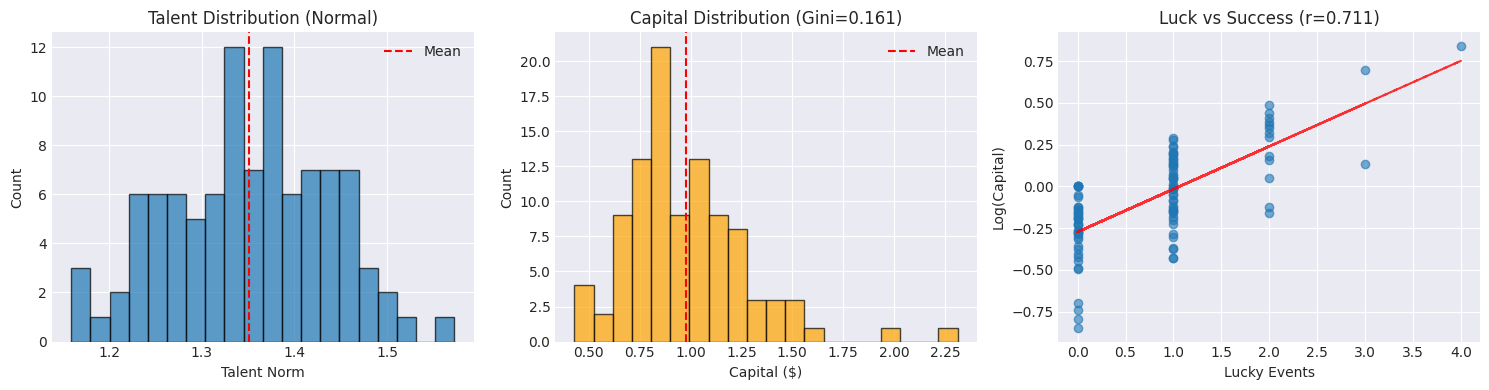


Key observation: Talent is normally distributed, but capital is skewed.
Correlation between luck and success is 0.711 (strong!)


In [11]:
# Create a larger population for better visualization
agents_vis = create_population(n_agents=100, seed=999)
agents_vis = run_simulation(agents_vis, n_periods=30, seed=999, verbose=False)
df_vis = get_results_dataframe(agents_vis)

# Create plots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Talent distribution
axes[0].hist(df_vis["talent_norm"], bins=20, edgecolor="black", alpha=0.7)
axes[0].set_xlabel("Talent Norm")
axes[0].set_ylabel("Count")
axes[0].set_title("Talent Distribution (Normal)")
axes[0].axvline(
    df_vis["talent_norm"].mean(), color="red", linestyle="dashed", label="Mean"
)
axes[0].legend()

# Plot 2: Capital distribution
axes[1].hist(
    df_vis["capital"], bins=20, edgecolor="black", alpha=0.7, color="orange"
)
axes[1].set_xlabel("Capital ($)")
axes[1].set_ylabel("Count")
axes[1].set_title(
    f"Capital Distribution (Gini={calculate_gini(df_vis['capital'].values):.3f})"
)
axes[1].axvline(
    df_vis["capital"].mean(), color="red", linestyle="dashed", label="Mean"
)
axes[1].legend()

# Plot 3: Luck vs Capital
axes[2].scatter(df_vis["lucky_events"], np.log(df_vis["capital"]), alpha=0.6)
axes[2].set_xlabel("Lucky Events")
axes[2].set_ylabel("Log(Capital)")
corr = df_vis["lucky_events"].corr(np.log(df_vis["capital"]))
axes[2].set_title(f"Luck vs Success (r={corr:.3f})")
z = np.polyfit(df_vis["lucky_events"], np.log(df_vis["capital"]), 1)
p = np.poly1d(z)
axes[2].plot(df_vis["lucky_events"], p(df_vis["lucky_events"]), "r--", alpha=0.8)

plt.tight_layout()
plt.show()

print(
    "\nKey observation: Talent is normally distributed, but capital is skewed."
)
print(f"Correlation between luck and success is {corr:.3f} (strong!)")

## Summary: What We Covered

This notebook walked through the core building blocks of the causal success model, step by step. Along the way, we demonstrated how each component works in isolation before combining them into larger analyses.

Specifically, we covered:

1. Creating individual agents with well-defined talent attributes  
2. Applying lucky and unlucky events using multiplicative dynamics  
3. Generating populations with realistically distributed talents  
4. Running simulations over time with configurable parameters  
5. Measuring inequality using standard metrics such as the Gini coefficient  
6. Converting simulation results into DataFrames for efficient analysis  
7. Producing comprehensive summary statistics in a single step  
8. Validating simulation outputs to ensure internal consistency  
9. Comparing alternative policy-based resource allocation rules  
10. Visualizing talent, capital, and luck to understand distributional patterns  

Together, these demos illustrate how simple stochastic mechanisms, when compounded over time, can generate unequal outcomes even from nearly identical starting conditions.

---

### Next steps

To see all of these components working together in a full analysis pipeline, open **`causal_success_example.ipynb`**, which integrates simulation, statistical analysis, and causal inference end to end.

For detailed technical documentation of the underlying functions and classes, refer to **`causal_success_API.md`**.

For the broader motivation, theoretical background, and interpretation of results, see **`README.md`**.

You now have a clear understanding of the individual pieces. The next notebookshows how they fit together.
